In [15]:
import numpy as np
import os
from sklearn.linear_model import LogisticRegression
import pandas as pd
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
import ast
import tensorflow as tf

In [3]:
EPIDURAL = INTRAPARENCHYMAL = INTRAVENTRICULAR = MULTI = SUBARACHNOID = ["brain_window", "max_contrast_window", "brain_bone_window", "subdural_window"]
SUBDURAL = OTHER = ["brain_window", "subdural_window","max_contrast_window", "brain_bone_window"]

In [4]:
FLAGGED = []
NOT_FOUND = 1010101

with open('hem_seg_labels/flagged.txt', 'r') as f:
    for id in f.readlines():
        FLAGGED.append(id.strip())

In [16]:
def generate_pixel_mask(dim, pixels):
    """
    Generate a pixel mask (2d np array of 0s, 1s) of dimension dim
    1s represent the border of the polygon determined by pixels, where pixels is
    [{'x': float, 'y': float}, ...]
    """
    mask = np.full((dim, dim), 2, dtype=int)
    vertices = []
    try:
        pixels = ast.literal_eval(pixels)
    except ValueError:
        return NOT_FOUND

    if len(pixels) == 1:
        if pixels[0]:
            pixels = pixels[0]
        else:
            return NOT_FOUND
    elif len(pixels) == 2:
        if pixels[0]:
            pixels = pixels[0]
        elif pixels[1]:
            pixels = pixels[1]
        else:
            return NOT_FOUND
    elif len(pixels) == 0:
        return NOT_FOUND

    for pixel in pixels:
        x = int(float(pixel['x']) * dim)
        y = int(float(pixel['y']) * dim)
        vertices.append((x, y))

    # Add bresenham's?
    draw_polygon(mask, vertices)

    mask = fill_polygon(mask)

    return mask

def fill_polygon(array):
    """
    Fill the inside of a polygon represented by 0s in a binary array with 0s.
    """
    filled_array = array.copy()

    # Find the leftmost and rightmost points of the polygon
    min_x = np.min(np.where(array == 1)[0])
    max_x = np.max(np.where(array == 1)[0])

    # Iterate through each row of the array
    for i in range(min_x, max_x + 1):
        row = array[i]

        # Find the leftmost and rightmost points of the polygon in this row
        leftmost = np.min(np.where(row == 1)[0])
        rightmost = np.max(np.where(row == 1)[0])

        # Fill the pixels between the leftmost and rightmost points
        filled_array[i, leftmost-3:leftmost] = 1
        filled_array[i, rightmost+2:rightmost+4] = 1
        filled_array[i, leftmost:rightmost+2] = 0

    return filled_array


# Bresenham's impl.
def draw_line(matrix, x0, y0, x1, y1):
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy

    while x0 != x1 or y0 != y1:
        # Set the pixel value to 1 (draw the edge)
        matrix[y0][x0] = 1
        e2 = 2 * err
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy


def draw_polygon(matrix, vertices):
    # Draw edges between consecutive vertices
    for i in range(len(vertices)):
        x0, y0 = vertices[i]
        x1, y1 = vertices[(i + 1) % len(vertices)]  # Wrap around to connect the last vertex with the first one
        draw_line(matrix, x0, y0, x1, y1)

In [22]:
def load_image(id, type, pref, mask_pixels):
    """
    Tries to load the image from the best available window, resizes it, cast byte color values to 0, 255
    creates a pixel mask from mask_pixels, and returns both
    """
    for window in pref:
        try:
            img = Image.open(f"dcms/{type}/{window}/{id}")
            img = img.resize((128, 128))
            img = ImageOps.grayscale(img)
            img = tf.cast(img, tf.float32) / 255.0
            
            mask = generate_pixel_mask(128, mask_pixels)
            
            if isinstance(mask, int):
                return NOT_FOUND

            # mask_img = np.array((255 * (1-mask)).astype(np.uint8))
            mask_img = tf.cast(mask, tf.uint8)
            # mask_img = tf.cast(mask_img, tf.uint8)
            # mask_img = tf.concat([mask_img] * 3, axis = -1)
            
            return img, mask_img
            
        except FileNotFoundError:
            continue

    # return a flag if nothing at all can be found
    return NOT_FOUND

In [23]:
def read_segmentation_labels(path):
    """
    Read in a csv of segmentation labels from path as a dataframe, drop extraneous columns and return
    """
    df = pd.read_csv(path)
    keep = ['Origin', 'Labeling State', 'Majority Label', 'Correct Label', 'Number of ROIs']
    subset_df = df[keep]

    del df
    
    drops = []
    for index, row in subset_df.iterrows():
        if row['Labeling State'] == 'In Progress' or row['Number of ROIs'] == '0':
            drops.append(index)

        elif row['Labeling State'] == 'Ready':
            subset_df.at[index, 'Label'] = row['Majority Label']

        else:
            subset_df.at[index, 'Label'] = row['Correct Label']

    subset_df.drop(drops, inplace=True)
    subset_df.drop(['Majority Label', 'Correct Label'], axis=1, inplace=True)

    return subset_df

In [24]:
paths = ['hem_seg_labels/epidural_segments.csv', 'hem_seg_labels/intraparenchymal_segments.csv', 'hem_seg_labels/multi_segments.csv', 'hem_seg_labels/subarachnoid_segments.csv', 'hem_seg_labels/subdural_segments.csv', 'hem_seg_labels/other_segments.csv']

# order: epidural, intrap, intrav (NO LABEL DATA), multi, subarach, subdural
labels = [read_segmentation_labels(path) for path in paths]
label_prefs = [EPIDURAL, INTRAPARENCHYMAL, MULTI, SUBARACHNOID, SUBDURAL, OTHER]
types = ["epidural", "intraparenchymal", "multi", "subarachnoid", "subdural", "intraventricular"]
classes = [1, 2, 3, 4, 5, 6]

x_train_1 = []
x_train_2 = []
y_train = []

x_test_1 = []
x_test_2 = []
y_test = []

for label_df, pref, type, cl in zip(labels, label_prefs, types, classes):
    num_rows = int(len(label_df) * 0.75)
    # Train Data
    for index, row in label_df.iloc[:num_rows].iterrows():
        if row['Origin'] not in FLAGGED:
            try:
                img, mask = load_image(row['Origin'], type, pref, row['Label'])
                x_train_1.append(img)
                x_train_2.append(mask)
                y_train.append(cl)
            except (TypeError, FileNotFoundError):
                continue
    # Test Data        
    for index, row in label_df.iloc[num_rows:].iterrows():
        if row['Origin'] not in FLAGGED:
            try:
                img, mask = load_image(row['Origin'], type, pref, row['Label'])
                x_test_1.append(img)
                x_test_2.append(mask)
                y_test.append(cl)
            except (TypeError, FileNotFoundError):
                continue

In [41]:
x_train_1 = np.array(x_train_1)
x_train_2 = np.array(x_train_2)
y_train = np.array(y_train)

x_test_1 = np.array(x_test_1)
x_test_2 = np.array(x_test_2)
y_test = np.array(y_test)

In [42]:
x_train = np.concatenate((x_train_1, x_train_2), axis=1)
x_test = np.concatenate((x_test_1, x_test_2), axis=1)

# Remove some intraventricular from the end
x_train = x_train[:-500]

In [43]:
length = len(x_train)

indices = np.arange(length)
np.random.shuffle(indices)

# Shuffle both arrays using the shuffled indices
x_train = np.array([x_train[i] for i in indices])
y_train = np.array([y_train[i] for i in indices])

In [44]:
length = len(x_test)

indices = np.arange(length)
np.random.shuffle(indices)

# Shuffle both arrays using the shuffled indices
x_test = np.array([x_test[i] for i in indices])
y_test = np.array([y_test[i] for i in indices])

In [46]:
x_train = x_train.reshape(x_train.shape[0], -1) 
x_test = x_test.reshape(x_test.shape[0], -1) 

(1896, 32768)

In [47]:
logreg = LogisticRegression(multi_class='multinomial', solver='sag', max_iter=5000)

logreg.fit(x_train, y_train)

c:\Users\mdfor\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


LogisticRegression(max_iter=2000, multi_class='multinomial', solver='sag')

In [48]:
score = logreg.score(x_test, y_test)
print("Logistic Regression Score:", score)

Logistic Regression Score: 0.3375959079283887


In [49]:
from sklearn.metrics import confusion_matrix

y_predict = logreg.predict(x_test)


conf_mx = confusion_matrix(y_test, y_predict)
conf_mx

array([[  7,  11,   2,   4,   6,  43],
       [ 13,  18,   6,   6,   9,  87],
       [  9,   7,   3,   2,   2,  36],
       [  3,  12,   3,   6,   2,  41],
       [  8,   8,   1,   1,   2,  44],
       [ 41,  49,  20,  26,  16, 228]], dtype=int64)

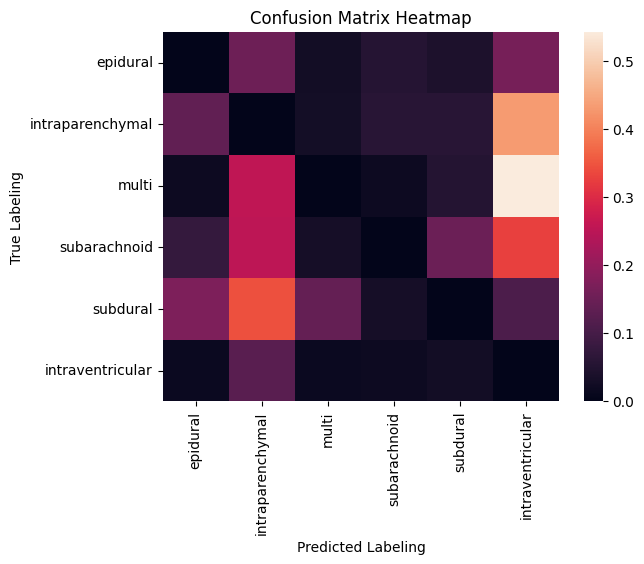

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

labels = ["epidural", "intraparenchymal", "multi", "subarachnoid", "subdural", "intraventricular"]

row_sum = conf_mx.sum(axis=1, keepdims=True)
nconf_mx = conf_mx/row_sum
np.fill_diagonal(nconf_mx,0)

sns.heatmap(nconf_mx, xticklabels=labels, yticklabels=labels)

plt.xlabel("Predicted Labeling")
plt.ylabel("True Labeling")
plt.title("Confusion Matrix Heatmap")
plt.savefig("Log_Segments_CM.png")